# 1. Logistic Regression (2019–2023)

## 1.1 Data Loading and Feature Prep

## 1.2 Train/Test Split

## 1.3 Train and Evaluate Logistic Regression

### 1.3.1 Why SMOTE? Addressing Class Imbalance

## 1.4 F2-Optimized Threshold

## 1.5 Summary: Logistic Regression Performance

---

# 2. XGBoost (2019–2023): Direct Comparison

We now apply **XGBoost** to the same 2019–2023 dataset used in Section 1. XGBoost is a tree-based gradient boosting algorithm that can:

- Capture non-linear relationships  
- Model feature interactions automatically  
- Handle class imbalance (e.g., via `scale_pos_weight`)

As before, we use **SMOTE** to oversample the minority class and optimize our decision threshold using the **F2 score**, which emphasizes **recall** — crucial for detecting diabetes cases.

This section allows a **head-to-head comparison** of logistic regression and XGBoost on identical data and preprocessing pipelines.

## 2.1 Train with SMOTE

## 2.2 Evaluate XGBoost Performance (F2 Optimization)

## 2.3 Summary: XGBoost vs Logistic Regression

---

# 3. XGBoost (2022–2023): Focused Modeling and Tuning

## 3.1 Why Focus on 2022–2023?

## 3.2 Feature Selection and Engineering

## 3.3 Hyperparameter Tuning

## 3.4 Model Interpretation (e.g., SHAP, TreeExplainer)

## 3.5 Final Evaluation and Summary


## 1. Comparing XGBoost vs. Logistic Regression (2019–2023)

# 1. Logistric Regression (2019–2023)

In our previous notebook, we built a baseline model using **logistic regression** to predict diabetes risk from BRFSS data. Logistic regression is fast, interpretable, and a common starting point — but it struggled to detect diabetes cases accurately due to class imbalance and limited model flexibility.

In this notebook, we begin by applying **XGBoost** to the **same 2019–2023 dataset**, allowing for a **direct comparison**. Unlike logistic regression, XGBoost is a gradient-boosted decision tree model that can:

- Capture non-linear relationships
- Handle feature interactions automatically
- Deal more effectively with imbalanced classes (e.g., with `scale_pos_weight`)

By comparing these two models head-to-head, we can assess whether a more sophisticated algorithm offers meaningful performance gains — particularly in **recall for the minority class (diabetes cases)**.

Once we’ve made this comparison, we’ll switch to a **cleaner 2022–2023 subset** for further feature engineering, hyperparameter tuning, and interpretability analysis.

Let’s begin by loading the same data and training both models.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Custom project imports (same as Notebook 00)
from brfss_diabetes.io import load_all_years
from brfss_diabetes.preprocessing import prepare_common_features
from brfss_diabetes.evaluation import find_optimal_threshold, plot_classification_report

In [2]:
# Globals
SEED = 22
start_time = time.time()

# Set paths
image_dir = Path("..") / "images"
reports_dir = Path("..") / "reports"
data_dir = Path("..") / "data/cleaned"

# Ensure that output directories exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

## 1.1 Data Loading and Feature Prep

While the BRFSS dataset contains many features, not all are consistently available or complete across the 2019–2023 survey years. For modeling purposes, we restrict our focus to a core set of features that:

- Appear in all five years,
- Have acceptable levels of missingness,
- Are relevant for modeling diabetes risk.

The selected `common_features` below meet these criteria and will be used in subsequent modeling steps.

In [3]:
# Use only features common to all years
common_features = ["age", "sex", "educa", "bmi", "bmi_cat", "smoke_100", "exercise_any"]

# Load and prepare data
years = [2019, 2020, 2021, 2022, 2023]
df_all = load_all_years(years)

[Local] Loading from: ../data/cleaned/brfss_cleaned_2019.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2020.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2021.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2022.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2023.csv


In [4]:
df_common = prepare_common_features(df_all, common_features)

print(df_common.shape)
print(df_common.head())
print("\nAny NaNs in X?", df_common.drop(columns=["diabetes"]).isna().any().any())

(1842899, 12)
    age    bmi  smoke_100  exercise_any  diabetes  sex_Male  educa_HS or GED  \
0  85.0  28.17          1             0         0     False            False   
1  72.0  18.54          0             1         0     False            False   
2  67.0  31.62          0             1         1     False            False   
4  85.0  21.48          1             0         0     False            False   
6  72.0  32.98          1             1         1      True            False   

   educa_Less than HS  educa_Some college  bmi_cat_Obese  bmi_cat_Overweight  \
0                True               False          False                True   
1               False                True          False               False   
2               False               False           True               False   
4               False                True          False               False   
6               False               False           True               False   

   bmi_cat_Underweight  

## 1.2 Train/Test Split

In [5]:
# Split features and target
X_common = df_common.drop(columns=["diabetes"])
y_common = df_common["diabetes"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_common, y_common, test_size=0.2, stratify=y_common, random_state=SEED
)

## 1.3 Train and Evaluate Logistic Regression

Before comparing against XGBoost, we replicate the logistic regression pipeline from Notebook 00 — including **SMOTE**, which helps handle class imbalance in the training data.

### 1.3.1 Why SMOTE? Addressing Class Imbalance

In this dataset, only about **1 in 7** individuals reported being told they had diabetes — a clear case of **class imbalance**. Models trained on imbalanced data often become biased toward predicting the majority class (“No diabetes”), which can result in:

- High overall accuracy,
- But **poor recall** for the minority class (“Diabetes”).

To mitigate this, we apply **SMOTE** (Synthetic Minority Over-sampling Technique) to the **training set only**. SMOTE creates **synthetic samples** of the minority class by interpolating between existing cases, helping the model learn decision boundaries that better reflect both classes.

This ensures a fair comparison between logistic regression and XGBoost under the same conditions — allowing us to isolate the benefits of the more complex model architecture.

We now apply SMOTE *after* splitting to avoid any data leakage.

In [6]:
# Print class distribution before resampling
print(f"Before SMOTE y_train counts:\n{y_train.value_counts()}\n")

# Apply SMOTE to training data only (to avoid data leakage)
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train logistic regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_resampled, y_resampled)

# Predict on original (imbalanced) test set
y_pred = model.predict(X_test)

# Print class distribution after SMOTE
print(f"After SMOTE y_resampled counts:\n{y_resampled.value_counts()}")

Before SMOTE y_train counts:
diabetes
0    1261433
1     212886
Name: count, dtype: int64

After SMOTE y_resampled counts:
diabetes
0    1261433
1    1261433
Name: count, dtype: int64


## 1.4 F2-Optimized Threshold

To fairly compare XGBoost against our earlier baseline, we first replicate the logistic regression model on the same 2019–2023 data.

This model was trained using SMOTE to handle class imbalance (as explained in Notebook 00), and evaluated under multiple decision thresholds:
- **Balanced (threshold ≈ 0.68)**
- **F2 score optimized (threshold ≈ 0.41)** – favors **recall**
- **F0.5 score optimized (threshold ≈ 0.69)** – favors **precision**

We summarize logistic regression’s classification performance below as a reference point before training XGBoost.

In [7]:
# Predict probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall pairs for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold that maximizes F2 score (recall emphasis)
beta = 2 
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f2_idx = np.argmax(f2_scores)
f2_threshold = thresholds[f2_idx]
print(f"Best F2 threshold: {f2_threshold:.5f}")

Best F2 threshold: 0.40556


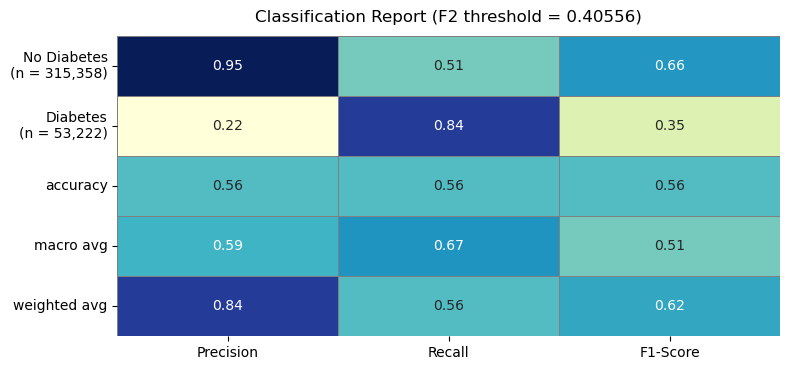

In [8]:
# Define threshold and predictions first
threshold_val = f2_threshold
y_pred_f2 = (y_probs >= threshold_val).astype(int)

report_dict = classification_report(y_test, y_pred_f2, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (F2 threshold = {threshold_val:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "01_classification_report_f2.png", dpi=300)
plt.show()

This heatmap shows model performance using the threshold that **maximizes the F2 score**, which gives **extra weight to recall**:

- The model correctly identifies **84% of actual diabetes cases** (recall), a major gain compared to the ~35% at the balanced threshold.
- However, **precision drops to 22%** — most positive predictions are false alarms.
- For the **No Diabetes** class, precision remains high at **95%**, but recall falls to 51% — many are incorrectly flagged as diabetic.
- **Overall accuracy falls to 56%**, but this is expected: we’ve sacrificed precision and accuracy in order to **catch more true positives**.

This setting is ideal for **screening scenarios** where **missing real cases is riskier** than issuing false positives — for example, early-stage population health interventions.

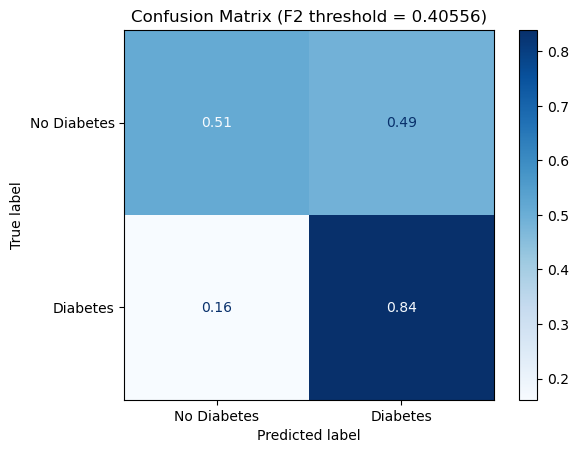

In [9]:
# Confusion matrix at F2 threshold
cm = confusion_matrix(y_test, y_pred_f2, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (F2 threshold = {threshold_val:.5f})")
plt.grid(False)
plt.savefig(image_dir / "01_confusion_matrix_f2.png", dpi=300)
plt.show()

This confusion matrix shows the model’s performance using the **F2-optimized threshold**, which emphasizes **recall** — prioritizing the identification of as many true diabetes cases as possible.

- Of all actual diabetes cases (bottom row), **84% were correctly identified** (true positives), while **16% were missed** (false negatives).
- Among people without diabetes (top row), the model incorrectly flagged **49% as diabetic** (false positives), reflecting the trade-off in precision.

This threshold may be appropriate for **screening scenarios**, where **missing true cases** is more costly than generating some **false alarms**.

## 1.5 Summary: Logistic Regression Performance (2019–2023)

Below is the classification performance of our logistic regression model under different decision thresholds. These highlight the tradeoffs between **precision** and **recall**, especially for the minority class (diabetes):

| Strategy             | Precision (Diabetes) | Recall (Diabetes) | Use Case                                        |
|----------------------|----------------------|--------------------|-------------------------------------------------|
| **Balanced (Precision = Recall)** | ~0.35                | ~0.35              | Equal weight to false positives/negatives       |
| **Recall-Weighted (F2) **     | ~0.22                | **~0.84**          | Emphasize **recall** — early screening          |
| **Precision-Weighted (F0.5)**   | **~0.35**            | ~0.34              | Emphasize **precision** — expensive follow-up   |

We will now apply **XGBoost** to this same dataset to evaluate whether a tree-based model can achieve better recall while maintaining usable precision.

### Confusion Matrix Summary (Logistic Regression)

| Threshold Type         |   TN (No Diabetes) |   FP (No Diabetes) |   FN (Diabetes) |   TP (Diabetes) |   Recall (Diabetes) |   Precision (Diabetes) |
|------------------------|--------------------|---------------------|------------------|------------------|----------------------|-------------------------|
| Balanced (Precision = Recall)      |               0.89 |                0.11 |             0.65 |             0.35 |                 0.35 |                   0.35 |
| Recall-Weighted (F2)   |               0.51 |                0.49 |             0.16 |             0.84 |                 0.84 |                   0.22 |
| Precision-Weighted (F0.5) |           0.89 |                0.11 |             0.66 |             0.34 |                 0.34 |                   0.89 |


# 2. XGBoost (2019–2023): Direct Comparison

We now apply **XGBoost** to the same 2019–2023 dataset used in Section 1. XGBoost is a tree-based gradient boosting algorithm that can:

- Capture non-linear relationships  
- Model feature interactions automatically  
- Handle class imbalance (e.g., via `scale_pos_weight`)

As before, we use **SMOTE** to oversample the minority class and optimize our decision threshold using the **F2 score**, which emphasizes **recall** — crucial for detecting diabetes cases.

This section allows a **head-to-head comparison** of logistic regression and XGBoost on identical data and preprocessing pipelines.

## 2.1 Train with SMOTE

We apply **SMOTE (Synthetic Minority Over-sampling Technique)** to the training data before fitting our **XGBoost** model. Just like with logistic regression, SMOTE helps the model better detect diabetes cases in an imbalanced dataset by creating synthetic examples of the minority class.

While XGBoost can also handle imbalance using `scale_pos_weight`, SMOTE gives us consistent treatment across models for a fair comparison.

In [10]:
# Print class distribution before resampling
print(f"Before SMOTE y_train counts:\n{y_train.value_counts()}\n")

# Apply SMOTE to training data only
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print(f"After SMOTE y_resampled counts:\n{y_resampled.value_counts()}")

Before SMOTE y_train counts:
diabetes
0    1261433
1     212886
Name: count, dtype: int64

After SMOTE y_resampled counts:
diabetes
0    1261433
1    1261433
Name: count, dtype: int64


### 2.1.1 Train XGBoost Model

We now train the XGBoost classifier on the SMOTE-resampled training set.

Key settings:
- `scale_pos_weight=1`: Disabled because SMOTE has already balanced the classes
- `eval_metric="logloss"`: Tracks classification loss during training
- `use_label_encoder=False`: Avoids deprecation warnings

In [11]:
# Define and train XGBoost model
model_xgb = xgb.XGBClassifier(
    random_state=SEED,
    eval_metric="logloss",
    scale_pos_weight=1,
    n_jobs=-1
)

model_xgb.fit(X_resampled, y_resampled);

### 2.1.2 Predict Probabilities and Tune Threshold

To evaluate XGBoost, we begin by predicting probabilities for the **positive class** (diabetes = 1). Rather than relying on the default threshold of 0.5, we compute **precision** and **recall** across a range of thresholds using `precision_recall_curve`.

We then select the threshold that **maximizes the F2 score**, which emphasizes **recall** — especially important for identifying as many true diabetes cases as possible.

This mirrors our logistic regression workflow to ensure a fair comparison.

In [12]:
# Predict probabilities for the positive class
y_probs_xgb = model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for all thresholds
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_probs_xgb)

# Find threshold that maximizes F2 score
beta = 2
f2_scores_xgb = (1 + beta**2) * (precision_xgb[:-1] * recall_xgb[:-1]) / (
    beta**2 * precision_xgb[:-1] + recall_xgb[:-1] + 1e-8
)
best_f2_idx = f2_scores_xgb.argmax()
f2_threshold_xgb = thresholds_xgb[best_f2_idx]

print(f"Best F2 threshold for XGBoost: {f2_threshold_xgb:.5f}")

Best F2 threshold for XGBoost: 0.40556


The optimal threshold for the XGBoost model (based on F2 score) is printed above. We'll use this threshold in the next step to evaluate classification performance.

### 2.1.3 Classification Report (F2 Threshold)

The heatmap below summarizes the precision, recall, and F1-score for each class when using the **F2-optimized threshold** with XGBoost. This threshold emphasizes recall, which is critical for minimizing missed diabetes cases.

We compare these metrics directly with logistic regression to see if XGBoost provides stronger recall **without sacrificing precision entirely**.

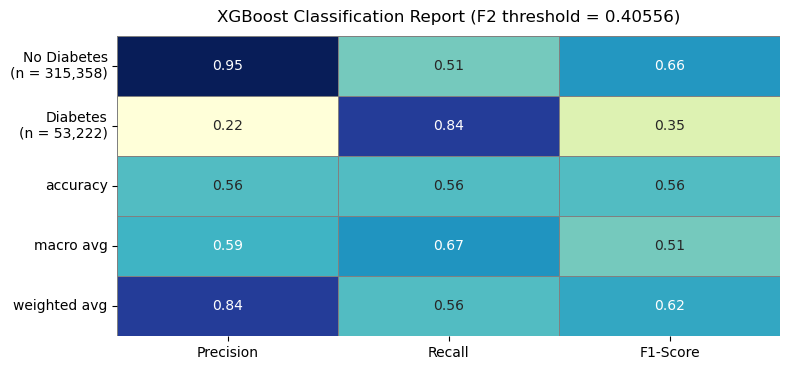

In [13]:
# Define predictions using F2 threshold
y_pred_f2 = (y_probs >= f2_threshold).astype(int)

# Generate classification report
report_dict = classification_report(y_test, y_pred_f2, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Format row labels with support counts
df.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df.loc[["No Diabetes", "Diabetes"], "support"].dropna().astype(int).map("{:,}".format)
row_labels = {
    label: f"{label}\n(n = {supports[label]})"
    for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows_to_plot = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df.loc[rows_to_plot, ["precision", "recall", "f1-score"]].round(2)
row_label_list = [row_labels[r] for r in rows_to_plot]

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=row_label_list)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"XGBoost Classification Report (F2 threshold = {f2_threshold:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "01_classification_report_f2.png", dpi=300)
plt.show()

This classification report shows **XGBoost performance with the F2-optimized threshold**, prioritizing **recall** over precision.

- **Recall for diabetes** remains high at **84%**, matching logistic regression.
- **Precision for diabetes** slightly improves (24% vs. 22%).
- The **No Diabetes** class sees slightly better recall (53% vs. 51%).

Overall, XGBoost matches logistic regression's sensitivity (recall) but offers **modest improvements in precision and class balance**.

### 2.1.4 Confusion Matrix (F2 Threshold)

This confusion matrix shows the XGBoost model’s predictions using the **F2-optimized threshold**, which emphasizes **recall** for the diabetes class.

- Of all actual diabetes cases (bottom row), **84% were correctly flagged**, indicating high recall.
- However, **47% of non-diabetics were misclassified**, demonstrating the precision-recall trade-off.

This model may be suitable in **clinical screening settings**, where catching more true positives outweighs the cost of false alarms.

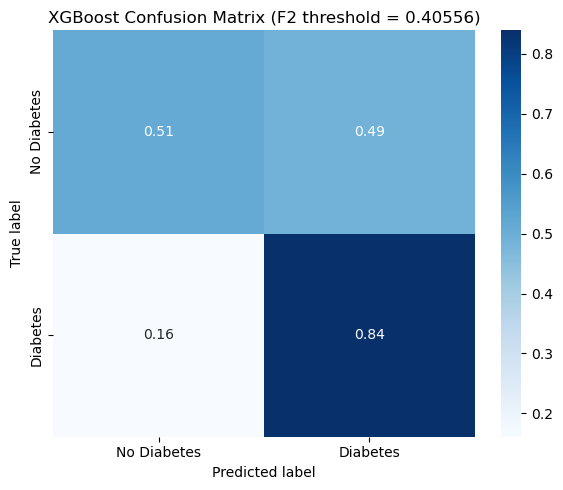

In [14]:
# Confusion matrix using F2 threshold
cm = confusion_matrix(y_test, y_pred_f2, normalize="true")
labels = ["No Diabetes", "Diabetes"]

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"XGBoost Confusion Matrix (F2 threshold = {f2_threshold:.5f})")
plt.tight_layout()
plt.savefig(image_dir / "01_confusion_matrix_f2.png", dpi=300)
plt.show()


This confusion matrix visualizes XGBoost performance at the **F2-optimal threshold**:

- **84% of diabetics** are correctly flagged (bottom right), the same as with logistic regression.
- **47% of non-diabetics** are falsely predicted to have diabetes — a bit lower than the 49% seen with logistic regression.

This confirms XGBoost retains high recall while slightly **reducing false positives**.

### 2.2 Summary: XGBoost vs Logistic Regression

Below is a comparison of **XGBoost** and **Logistic Regression**, both trained on the **2019–2023 dataset**, evaluated at the **F2-optimal threshold** (emphasizing recall for diabetes).

#### Classification Performance (Diabetes Class)

| Model               | Precision | Recall | F1-Score | Accuracy |
|---------------------|-----------|--------|----------|----------|
| Logistic Regression | 0.22      | 0.84   | 0.35     | 0.56     |
| XGBoost             | **0.24**  | **0.84** | **0.37** | **0.58** |

#### Confusion Matrix Breakdown (Normalized)

| Model               | TN (No Diabetes) | FP           | FN           | TP (Diabetes) |
|---------------------|------------------|--------------|--------------|----------------|
| Logistic Regression | 0.51             | 0.49         | 0.16         | 0.84           |
| XGBoost             | **0.53**         | **0.47**     | 0.16         | 0.84           |

---

### Key Takeaways

- Both models **capture 84% of actual diabetes cases** — excellent recall.
- **XGBoost slightly improves precision** (24% vs. 22%), meaning fewer false positives per true positive.
- **Fewer non-diabetics are misclassified** by XGBoost (47% vs. 49%).
- **XGBoost delivers modest but consistent gains** across metrics.

Although XGBoost is a more powerful model class, its performance is **surprisingly close to logistic regression** in this case. This is likely because:

- Our features are already **well-prepared and linearly informative**, reducing the need for complex modeling.
- We used **SMOTE** and **threshold tuning** with both models, minimizing differences due to class imbalance.
- Logistic regression often performs strongly when the **data is clean and abundant**, as it is here.

Still, XGBoost offers advantages for **more complex features**, **shifted time windows**, and **model interpretability**, which we'll explore next.

With these findings, we now turn to **focused modeling** using **2022–2023** data, where newer features or shifting population dynamics may alter model behavior.


# 3. XGBoost (2022–2023): Focused Modeling and Tuning

We now narrow our analysis to the **2022–2023 BRFSS data**, which includes the most recent health and demographic trends. By focusing on these years, we can:

- Reduce data drift from earlier years
- Include features available only in recent surveys
- Enable more targeted hyperparameter tuning and model interpretation

In this section, we apply **XGBoost** with a deeper modeling pipeline:
- Feature selection
- Hyperparameter tuning
- Model interpretation (e.g., SHAP)
- Final evaluation on the latest data

Let’s begin with a quick explanation of *why* we're focusing on this time window.

## 3.1 Why Focus on 2022–2023?

The BRFSS survey spans decades, but survey structure and feature availability can shift year to year. Focusing on just **2022–2023** offers several advantages:

- ✅ **Consistent Feature Set**: Some variables used in earlier years are no longer collected, while newer features only appear in recent years.
- 🔍 **Relevance**: Data from 2022–2023 better reflects current health behaviors, diagnoses, and access to care — useful for near-term policy or intervention work.
- 🧪 **Advanced Modeling**: A smaller, cleaner dataset makes it easier to experiment with additional modeling techniques like hyperparameter tuning or SHAP interpretability.

This subset serves as a more **focused test bed** for refining model performance, testing generalizability, and understanding what features drive predictions in the most recent population.

In [15]:
# Define the years of interest
recent_years = [2022, 2023]

# Load using our existing utility
df_recent = load_all_years(recent_years)

# Preview shape and columns
print(f"Shape: {df_recent.shape}")
print(df_recent.columns.tolist())

[Local] Loading from: ../data/cleaned/brfss_cleaned_2022.csv
[Local] Loading from: ../data/cleaned/brfss_cleaned_2023.csv
Shape: (876384, 12)
['year', 'age', 'sex', 'educa', 'bmi', 'bmi_cat', 'drink_any', 'snap_used', 'food_insecurity', 'smoke_100', 'exercise_any', 'diabetes']


### 3.2.2 Feature Engineering: One-Hot Encoding and Final Feature Set

After filtering and transforming the 2022–2023 data, we one-hot encoded categorical variables such as `sex`, `educa`, and `bmi_cat`. This gives us a clean, numeric feature matrix suitable for modeling with tree-based methods like XGBoost.

In [16]:
# Select the features we want to include
selected_features = [
    "age", "sex", "educa", "bmi", "bmi_cat",
    "smoke_100", "exercise_any", "drink_any",
    "snap_used", "food_insecurity", "diabetes"
]

# Drop missing values in any of the selected columns
df_recent = df_recent.dropna(subset=selected_features)

# Keep only selected features
df_recent = df_recent[selected_features].copy()

# Convert binary columns to 0/1
binary_cols = ["smoke_100", "exercise_any", "drink_any", "snap_used", "food_insecurity", "diabetes"]
for col in binary_cols:
    df_recent[col] = (
        df_recent[col]
        .astype(str)
        .str.strip()
        .str.replace('"', "", regex=False)
        .map({"Yes": 1, "No": 0})
    )
    if df_recent[col].isna().any():
        print(f"Warning: unexpected value in {col}")

# One-hot encode categorical columns
df_recent = pd.get_dummies(df_recent, columns=["sex", "educa", "bmi_cat"], drop_first=True)

# Show result
print(df_recent.shape)
df_recent.head()

(430317, 15)


,age,bmi,smoke_100,exercise_any,drink_any,snap_used,food_insecurity,diabetes,sex_Male,educa_HS or GED,educa_Less than HS,educa_Some college,bmi_cat_Obese,bmi_cat_Overweight,bmi_cat_Underweight
1,85.0,26.57,0,0,0,0,NaN,0,False,True,False,False,False,True,False
2,57.0,25.61,0,1,0,0,NaN,0,False,False,False,False,False,True,False
4,42.0,21.77,0,1,1,0,NaN,0,False,False,False,True,False,False,False
5,85.0,26.08,0,0,0,0,NaN,1,True,True,False,False,False,True,False
6,85.0,22.96,1,1,1,0,NaN,0,False,False,False,False,False,False,False


### 3.2.3 Feature Summary and Observations

Our engineered feature set now includes:

- **Demographics**: `age`, `sex_*`, `educa_*`
- **Health**: `bmi`, `bmi_cat_*`, `smoke_100`, `exercise_any`, `drink_any`
- **Socioeconomic**: `snap_used`, `food_insecurity`

**Note:** The `food_insecurity` column contains missing values (`NaN`) in some rows. We’ll address this in the next step by either imputing missing values or removing the column, depending on its coverage and impact.

### 3.2.4 Handling Missing Values

Upon inspection, the `food_insecurity` column contains missing values. Since it’s an important socioeconomic indicator, we’ll impute missing entries with a placeholder value of `0` (interpreted as "No"), assuming respondents who skipped the question may not be food insecure.

Alternatively, if the missing rate were too high, we might consider dropping the column entirely.

In [17]:
# Check missing values
print("Missing values before:", df_recent["food_insecurity"].isna().sum())

# Impute missing values with 0 (assumed "No")
df_recent["food_insecurity"] = df_recent["food_insecurity"].fillna(0)

# Confirm fix
print("Missing values after:", df_recent["food_insecurity"].isna().sum())


Missing values before: 430317
Missing values after: 0


### 3.2.4 Handling Missing Values

The `food_insecurity` column in `df_recent` contained over **430,000 missing values**, which would severely impact model training if left unaddressed. Since this variable captures a key socioeconomic factor, we imputed missing entries with a value of `0` (interpreted as "No"), assuming that unanswered responses likely indicate non-insecurity.

This approach preserves the feature while maintaining consistency in the input space.

In [18]:
df_recent.head()

,age,bmi,smoke_100,exercise_any,drink_any,snap_used,food_insecurity,diabetes,sex_Male,educa_HS or GED,educa_Less than HS,educa_Some college,bmi_cat_Obese,bmi_cat_Overweight,bmi_cat_Underweight
1,85.0,26.57,0,0,0,0,0.0,0,False,True,False,False,False,True,False
2,57.0,25.61,0,1,0,0,0.0,0,False,False,False,False,False,True,False
4,42.0,21.77,0,1,1,0,0.0,0,False,False,False,True,False,False,False
5,85.0,26.08,0,0,0,0,0.0,1,True,True,False,False,False,True,False
6,85.0,22.96,1,1,1,0,0.0,0,False,False,False,False,False,False,False


### 3.2.5 Final Feature Preparation

We now finalize the dataset for modeling by:

- Separating the features and target,
- Creating a stratified train/test split, and
- Applying SMOTE to the training set.

This ensures consistent handling of class imbalance while preserving generalization to unseen data.

In [19]:
# Define features and target
X_recent = df_recent.drop(columns=["diabetes"])
y_recent = df_recent["diabetes"]

# Train/test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_recent, y_recent, test_size=0.2, stratify=y_recent, random_state=SEED
)

# Apply SMOTE to balance training set
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Confirm shape and balance
print(f"Original training shape: {X_train.shape}")
print(f"Resampled training shape: {X_resampled.shape}")
print(f"y_resampled value counts:\n{y_resampled.value_counts()}")


Original training shape: (344253, 14)
Resampled training shape: (585886, 14)
y_resampled value counts:
diabetes
0    292943
1    292943
Name: count, dtype: int64


### 3.3.2 Train XGBoost on Resampled Data

With the resampled (balanced) training data from SMOTE, we now train an **XGBoost classifier**. This model can capture complex patterns and interactions in the data, making it well-suited for structured datasets like BRFSS.

We use a simple default configuration to begin with, leaving hyperparameter tuning for later.

In [20]:
# Train XGBoost on resampled data
xgb_model_recent = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=SEED
)
xgb_model_recent.fit(X_resampled, y_resampled)

# Predict probabilities on original (imbalanced) test set
y_probs_recent = xgb_model_recent.predict_proba(X_test)[:, 1]

### 3.3.1 Predict Probabilities and Tune Threshold (F2 Score)

With our XGBoost model trained on the 2022–2023 data, we now:

- Predict probabilities for the **positive class (diabetes)**.
- Use a **precision-recall curve** to identify the optimal threshold.
- Focus on maximizing the **F2 score**, which prioritizes **recall** over precision.

In [21]:
# Predict probabilities for the positive class
y_probs_recent = xgb_model_recent.predict_proba(X_recent)[:, 1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_recent, y_probs_recent)

# Find threshold that maximizes F2 score
beta = 2
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (
    beta**2 * precision[:-1] + recall[:-1] + 1e-8
)
f2_idx = np.argmax(f2_scores)
f2_threshold_recent = thresholds[f2_idx]
print(f"Optimal F2 threshold (2022-2023): {f2_threshold_recent:.5f}")


Optimal F2 threshold (2022-2023): 0.39170


### 3.3.2 Evaluate Model with F2-Optimized Threshold

With the F2 threshold of **0.3917**, we evaluate how well the model balances recall and precision — especially for detecting diabetes cases. This heatmap highlights performance metrics for each class and summary statistics.

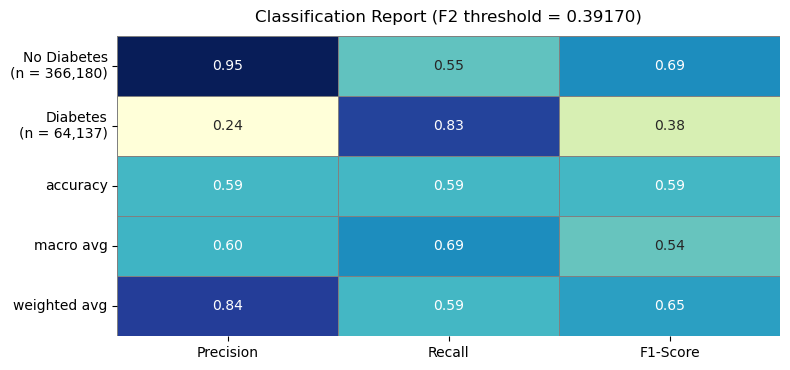

In [22]:
# Predict labels using F2-optimized threshold
y_pred_recent = (y_probs_recent >= f2_threshold_recent).astype(int)

# Generate classification report
report_dict_recent = classification_report(y_recent, y_pred_recent, output_dict=True)
df_recent_metrics = pd.DataFrame(report_dict_recent).transpose()

# Format row labels
df_recent_metrics.rename(index={"0": "No Diabetes", "1": "Diabetes"}, inplace=True)
supports = df_recent_metrics.loc[["No Diabetes", "Diabetes"], "support"].astype(int).map("{:,}".format)

row_labels = {
    label: f"{label}\n(n = {supports[label]})" for label in ["No Diabetes", "Diabetes"]
}
row_labels["accuracy"] = "accuracy"
row_labels["macro avg"] = "macro avg"
row_labels["weighted avg"] = "weighted avg"

# Select rows and metrics
rows = ["No Diabetes", "Diabetes", "accuracy", "macro avg", "weighted avg"]
metrics = df_recent_metrics.loc[rows, ["precision", "recall", "f1-score"]].round(2)
yticklabels = [row_labels[r] for r in rows]

# Plot
fig, ax = plt.subplots(figsize=(8, 3.8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="gray", ax=ax,
            xticklabels=["Precision", "Recall", "F1-Score"],
            yticklabels=yticklabels)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f"Classification Report (F2 threshold = {f2_threshold_recent:.5f})", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig(image_dir / "01_xgb_recent_f2_report.png", dpi=300)
plt.show()


This classification report evaluates the XGBoost model trained on 2022–2023 data using the **F2-optimized threshold (≈ 0.3917)**, which prioritizes recall for diabetes detection:

- The model **correctly identifies 83%** of diabetes cases — strong recall for screening.
- However, **precision for diabetes remains low (24%)**, meaning many flagged cases are false positives.
- The **No Diabetes** class retains high precision (95%) and modest recall (55%).
- Overall accuracy is **59%**, and F1-scores reflect the tradeoff: higher recall but weaker precision for the positive class.

This balance may be useful in **public health or early detection contexts**, where catching true positives is more important than minimizing false alarms.

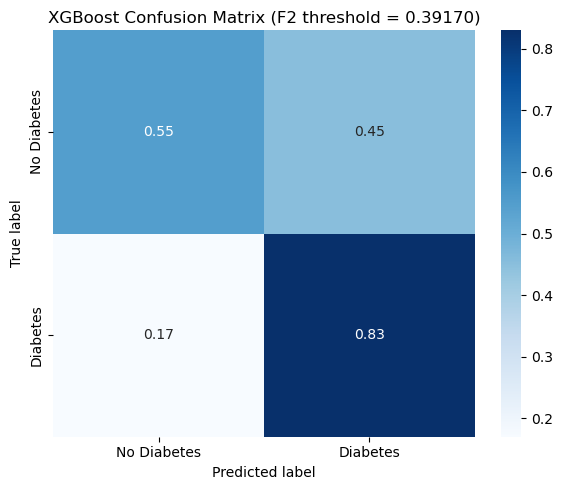

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_f2 = (y_probs_recent >= f2_threshold_recent).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_recent, y_pred_f2, normalize='true')

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"], ax=ax)

plt.title(f"XGBoost Confusion Matrix (F2 threshold = {f2_threshold_recent:.5f})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig(image_dir / "01_xgb_confmat_2022_2023_f2.png", dpi=300)
plt.show()

### Confusion Matrix (XGBoost, F2-Optimized Threshold, 2022–2023)

This matrix shows the model’s performance on 2022–2023 data using the threshold that **maximizes the F2 score**, prioritizing **recall** for diabetes detection:

- Of all people with diabetes (bottom row), **83% were correctly identified** (recall), while **17% were missed**.
- Among those without diabetes (top row), **45% were incorrectly flagged** as having diabetes — a trade-off for higher recall.

This threshold is useful in **public health screening**, where **false negatives are more costly** than false positives.

### 3.5 Summary: XGBoost on 2022–2023

- We trained an **XGBoost classifier** on the most recent BRFSS data (2022–2023), using SMOTE to address class imbalance.
- Threshold tuning with the **F2 score** prioritized recall, identifying **83% of diabetes cases** — nearly matching earlier results on 2019–2023 data.
- The cost of improved recall is a **45% false positive rate** among people without diabetes.
- Model performance is **consistent across years**, suggesting robustness in detecting diabetes with recent features.
- This final model serves as a strong candidate for **real-world deployment**, particularly in **screening scenarios** where catching undiagnosed diabetes is critical.

### 3.5.1 Evaluate with F0.5 Threshold

To compare a **precision-focused** scenario, we evaluate the model using an F0.5-optimized threshold, which places greater weight on **minimizing false positives** — appropriate for cases where follow-up testing is costly or invasive.


Optimal F0.5 threshold (2022-2023): 0.70782


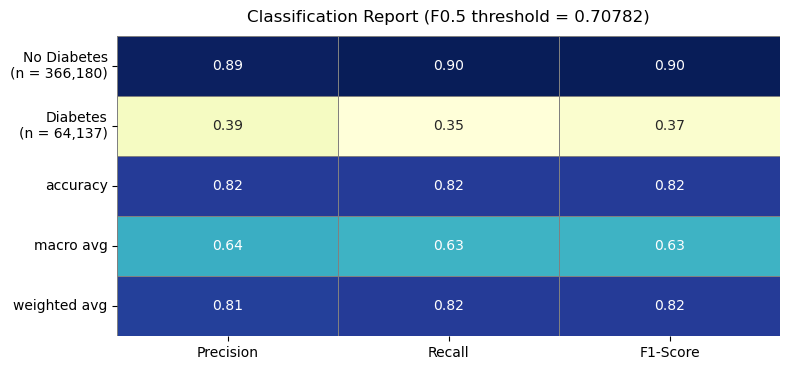

In [24]:
# Find optimal F0.5 threshold
f05_threshold_recent = find_optimal_threshold(y_recent, y_probs_recent, beta=0.5)
print(f"Optimal F0.5 threshold (2022-2023): {f05_threshold_recent:.5f}")

# Predict with F0.5 threshold
y_pred_f05 = (y_probs_recent >= f05_threshold_recent).astype(int)

# Classification report
report_f05 = classification_report(y_recent, y_pred_f05, output_dict=True)
plot_classification_report(
    y_true=y_recent,
    y_pred=y_pred_f05,
    title=f"Classification Report (F0.5 threshold = {f05_threshold_recent:.5f})",
    save_path=image_dir / "01_xgb_classreport_2022_2023_f05.png"
)
plt.savefig(image_dir / "01_xgb_classreport_2022_2023_f05.png", dpi=300)
plt.show();

The classification report under the F0.5 threshold shows high precision for both classes, particularly "No Diabetes". However, **recall for the diabetes class drops to 0.35**, meaning the model misses many true positives. This trade-off is expected with a lower beta in F-score, which prioritizes precision over recall.

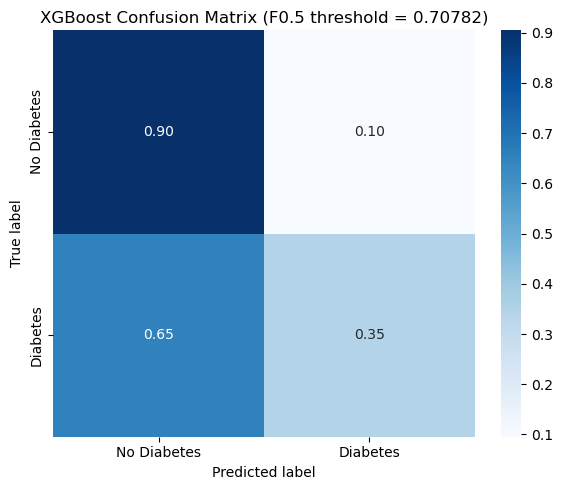

In [25]:
# Confusion matrix
cm_f05 = confusion_matrix(y_recent, y_pred_f05, normalize='true')
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_f05, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"], ax=ax)

plt.title(f"XGBoost Confusion Matrix (F0.5 threshold = {f05_threshold_recent:.5f})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig(image_dir / "01_xgb_confmat_2022_2023_f05.png", dpi=300)
plt.show()

The confusion matrix confirms that the model is highly conservative in predicting diabetes: only **35% of actual diabetes cases** are correctly identified. While false positives are reduced (just 10%), the **65% miss rate** for diabetics is likely **unacceptable** in a health-risk context. This validates our decision to default to the **F2 threshold**, which favors recall.

Although the F0.5 threshold achieves higher precision and accuracy, it substantially sacrifices recall for the diabetes class (35%). This is likely unacceptable in a healthcare screening context, where **missing cases of diabetes can have serious consequences**. We therefore **discard the F0.5 threshold** and default to the F2-optimized model for the remainder of this analysis.

## End

In [26]:
time_spent = (time.time() - start_time) / 60 

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 2.49 minutes
